# Decision Tree: Iterative Dichomiser 3 (ID3)
# Cây quyết định và thuật toán ID3

## 1. Tổng quan

Decision tree là một mô hình supervised learning, có thể được áp dụng vào cả hai bài toán classification và regression. Việc xây dựng một decision tree trên dữ liệu huấn luyện cho trước là việc đi xác định các câu hỏi và thứ tự của chúng. Một điểm đáng lưu ý của decision tree là nó có thể làm việc với các đặc trưng (trong các tài liệu về decision tree, các đặc trưng thường được gọi là thuộc tính – attribute) dạng categorical, thường là rời rạc và không có thứ tự. Ví dụ, mưa, nắng hay xanh, đỏ, v.v. Decision tree cũng làm việc với dữ liệu có vector đặc trưng bao gồm cả thuộc tính dạng categorical và liên tục (numeric). Một điểm đáng lưu ý nữa là decision tree ít yêu cầu việc chuẩn hoá dữ liệu.

<img src="img/dt_1.png" width="400">

ID3 là một thuật toán decision tree được áp dụng cho các bài toán classification mà tất cả các thuộc tính đều ở dạng categorical. Trong ID3, chúng ta cần xác định thứ tự của thuộc tính cần được xem xét tại mỗi bước. Một số các đại lượng quan trọng trong thuật toán ID3: Hàm số entropy, Entropy tại node của cây, tổng số Entropy tại mỗi Child_node, information gain của thuộc tính.

<img src="img/dt_2.png" width="600">
<img src="img/dt_3.png" width="600">
<img src="img/dt_4.png" width="600">
<img src="img/dt_5.png" width="600">

## 2. Cài đặt thuật toán

### Các thư viện được sử dụng

In [1]:
import pandas as pd
import math as mt
from collections import Counter

### Hàm tính toán Entropy
Sử dụng hàm `log` cơ số e, có thể sử dụng hàm `log` cơ số 2 thay thế.

In [2]:
# Function to calculate the entropy of probaility of observations
def entropy(probs):
    return sum([-prob * mt.log(prob, 2) for prob in probs])

### Hàm tính toán Entropy với đầu vào là một dãy
Hàm `Counter` đầu ra là một dict bao gồm keys là phần tử, value là số lần xuất hiện của phần tử đó trong dãy.

In [3]:
# Function to calulate the entropy of the given Data Sets/List with respect to target attributes
def entropy_of_list(a_list):
    cnt = Counter(x for x in a_list)
    num_instances = len(a_list)
    probs = [x/num_instances for x in cnt.values()]
    return entropy(probs)

### Hàm tính toán information gain của thuộc tính
Sử dụng các hàm trong pandas: `groupby`, `agg`

In [4]:
# Information gain of Attributes
def information_gain(df, split_attribute_name, target_attribute_name, trace=0):
    # split data by possible vals of attribute
    df_split = df.groupby(split_attribute_name)
    # proportion of Obs in Each data_split
    nobs = len(df.index)
    df_agg_ent = df_split.agg({target_attribute_name: [entropy_of_list, lambda x: len(x) / nobs]})[
        target_attribute_name]
    df_agg_ent.columns = ['Entropy', 'PropObservations']
    # Calculate Information Gain:
    new_entropy = sum(df_agg_ent['Entropy'] * df_agg_ent['PropObservations'])
    old_entropy = entropy_of_list(df[target_attribute_name])
    return old_entropy - new_entropy

### Hàm thực thi thuật toán ID3

In [5]:
# ID3 Algorithm
def id3_algorithm(df, target_attribute_name, attribute_names, default_class=None):
    cnt = Counter(x for x in df[target_attribute_name])
    if len(cnt) == 1:
        return next(iter(cnt))
    elif df.empty or (not attribute_names):
        return default_class
    else:
        # Get Default Value for next recursive call of this function:
        default_class = max(cnt.keys())
        # Compute the information gain of the attribute:
        gainz = [information_gain(df, attr, target_attribute_name) for attr in attribute_names]
        # index of best attribute
        index_of_max = gainz.index(max(gainz))
        # choose best attribute to split on
        best_attr = attribute_names[index_of_max]
        # create an empty tree, to be populated in a moment
        # Iniiate the tree with best attribute as a node
        tree = {best_attr: {}}
        remaining_attribute_names = [i for i in attribute_names if i != best_attr]
        # Split dataset
        # On each split, recursively call this algorithm.
        # populate the empty tree with subtrees, which
        # are the result of the recursive call
        for attr_val, data_subset in df.groupby(best_attr):
            subtree = id3_algorithm(data_subset, target_attribute_name, remaining_attribute_names, default_class)
            tree[best_attr][attr_val] = subtree
        return tree

### Độ chính xác của cây quyết định

In [6]:
# Classification accuracy
def classify(instance, tree, default=None):
    # instance of play tennis with predict
    attribute = next(iter(tree))
    if instance[attribute] in tree[attribute].keys():  # Value of the attributs in  set of Tree keys
        result = tree[attribute][instance[attribute]]
        if isinstance(result, dict):  # this is a tree, delve deeper
            return classify(instance, result)
        else:
            return result  # this is a label
    else:
        return default

## 3. Bài toán cụ thể

### Dữ liệu

Dữ liệu này mô tả mối quan hệ giữa thời tiết trong 14 ngày (bốn cột đầu, không tính cột id) và việc một đội bóng có chơi bóng hay không (cột cuối cùng). Nói cách khác, ta phải dự đoán giá trị ở cột cuối cùng nếu biết giá trị của bốn cột còn lại.

In [7]:
df_tennis = pd.read_csv("weather.csv")
print(df_tennis)

    id   outlook temperature humidity    wind play
0    1     sunny         hot     high    weak   no
1    2     sunny         hot     high  strong   no
2    3  overcast         hot     high    weak  yes
3    4     rainy        mild     high    weak  yes
4    5     rainy        cool   normal    weak  yes
5    6     rainy        cool   normal  strong   no
6    7  overcast        cool   normal  strong  yes
7    8     sunny        mild     high    weak   no
8    9     sunny        cool   normal    weak  yes
9   10     rainy        mild   normal    weak  yes
10  11     sunny        mild   normal  strong  yes
11  12  overcast        mild     high  strong  yes
12  13  overcast         hot   normal    weak  yes
13  14     rainy        mild     high  strong   no


### Tính toán entropy tại node gốc

In [8]:
total_entropy = entropy_of_list(df_tennis['play'])
print("\n Total Entropy of PlayTennis Data Set:",total_entropy)


 Total Entropy of PlayTennis Data Set: 0.9402859586706309


Trong bài viết machine learning cơ bản, cơ số được sử dụng là log cơ số `e`.
<img src="img/dt_6.png" width="700">

### Tính toán iformation gain của các thuộc tính: `outlook`, `temperature`, `humidity` và `wind`

In [9]:
print('Info-gain for Outlook is :'+str( information_gain(df_tennis, 'outlook', 'play')),"\n")
print('\n Info-gain for Humidity is: ' + str( information_gain(df_tennis, 'humidity', 'play')),"\n")
print('\n Info-gain for Wind is:' + str( information_gain(df_tennis, 'wind', 'play')),"\n")
print('\n Info-gain for Temperature is:' + str( information_gain(df_tennis, 'temperature','play')),"\n")

Info-gain for Outlook is :0.2467498197744391 


 Info-gain for Humidity is: 0.15183550136234136 


 Info-gain for Wind is:0.04812703040826927 


 Info-gain for Temperature is:0.029222565658954647 



Rõ ràng thuộc tính `outlook` sẽ được chọn vì có info-gain lớn nhất so với 3 thuộc tính còn lại, nên root = 'outlook'.

### Xây dựng cây quyết định bằng thuật toán ID3

In [10]:
attribute_names = list(df_tennis.columns)
print("List of Attributes:", attribute_names)
# Remove the class attribute
attribute_names.remove('play')
attribute_names.remove('id')
print("Predicting Attributes:", attribute_names)
tree = id3_algorithm(df_tennis, 'play', attribute_names)
print("Decision tree:\n",tree)

List of Attributes: ['id', 'outlook', 'temperature', 'humidity', 'wind', 'play']
Predicting Attributes: ['outlook', 'temperature', 'humidity', 'wind']
Decision tree:
 {'outlook': {'overcast': 'yes', 'rainy': {'wind': {'strong': 'no', 'weak': 'yes'}}, 'sunny': {'humidity': {'high': 'no', 'normal': 'yes'}}}}


Cây quyết định ta xây dựng được phù hợp với cây quyết định trên bài viết ML_cơ bản.

### Độ chính xác của cây quyết định

In [14]:
print("Decision tree predict:")
df_tennis['predicted'] = df_tennis.apply(classify, axis=1, args=(tree, 'No'))
print(df_tennis['predicted'])
print('\n Accuracy is:\n' + str( sum(df_tennis['play']==df_tennis['predicted'] ) / (1.0*len(df_tennis.index)) ))
df_tennis[['play', 'predicted']]

Decision tree predict:
0      no
1      no
2     yes
3     yes
4     yes
5      no
6     yes
7      no
8     yes
9     yes
10    yes
11    yes
12    yes
13     no
Name: predicted, dtype: object

 Accuracy is:
1.0


,play,predicted
0,no,no
1,no,no
2,yes,yes
3,yes,yes
4,yes,yes
5,no,no
6,yes,yes
7,no,no
8,yes,yes
9,yes,yes


### Chia dữ liệu và dự đoán

In [23]:
training_data = df_tennis.iloc[1:-4] # all but last four instances
test_data  = df_tennis.iloc[-4:] # just the last four
train_tree = id3_algorithm(training_data, 'play', attribute_names)
test_data['predicted2'] = test_data.apply(                               
                                          classify, 
                                          axis=1, 
                                          args=(train_tree,'Yes') ) 


print ('\n\n Accuracy is : ' + str( sum(test_data['play']==test_data['predicted2'] ) / (1.0*len(test_data.index)) ))



 Accuracy is : 0.75


c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Như vậy khi ta chia dữ liệu thành hai phần thì độ chính xác của mô hình là `75%`.

## 4. Sử dụng thư viện Sklearn trong python


In [15]:
from sklearn.datasets import load_iris
from sklearn import tree

In [16]:
X, y = load_iris(return_X_y=True)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

[Text(167.4, 199.32, 'X[2] <= 2.45\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(141.64615384615385, 163.07999999999998, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(193.15384615384616, 163.07999999999998, 'X[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(103.01538461538462, 126.83999999999999, 'X[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(51.50769230769231, 90.6, 'X[3] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(25.753846153846155, 54.359999999999985, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(77.26153846153846, 54.359999999999985, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(154.52307692307693, 90.6, 'X[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(128.76923076923077, 54.359999999999985, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(180.27692307692308, 54.359999999999985, 'X[2] <= 5.45\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(154.5230

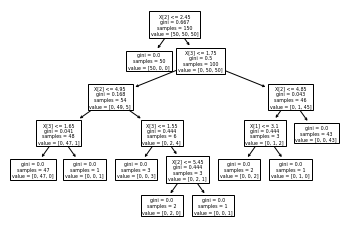

In [17]:
tree.plot_tree(clf) 

## 5. Tài liệu tham khảo

1. https://machinelearningcoban.com/2018/01/14/id3/
2. https://github.com/profthyagu/Python-Decision-Tree-Using-ID3
3. https://scikit-learn.org/stable/modules/tree.html

# End